# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.unilm import *

In [9]:
config = unilm_config(vocab)

In [10]:
# config['bs'] = 2
# config['bptt'] = 1024
# config['n_layers'] = 4
# config['n_heads'] = 4
# config['dec_layers'] = 2

In [11]:
config

{'ctx_len': 150,
 'n_layers': 10,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': True,
 'note_range': (9, 139),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 274,
 'dec_layers': 6}

In [12]:
base_path = Path('../../data/midi/v15/')

In [13]:
cache_name = 'tmp/sample'

## BERT Dataloading

In [14]:
ns_dl_tfms = [mask_tfm, next_sentence_tfm]
ns_config = config.copy()
ns_config['bs'] *= 2
ns_data = load_music_data(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                          y_offset=0, dl_tfms=ns_dl_tfms, **ns_config)

## S2S Dataloading

In [15]:
s2s_dl_tfms = [mask_s2s_tfm]
s2s_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                           preloader_cls=S2SPreloader, dl_tfms=[mask_s2s_tfm], y_offset=1,
                           shuffle_dl=True, **config)


### Load NextWord dataset (Language Model)

In [16]:
nw_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, 
                              vocab=vocab, dl_tfms=[nw_tfm], y_offset=1, 
                              train_tfms=[to_single_stream], valid_tfms=[to_single_stream], **config)

In [17]:
xb,yb = nw_data.one_batch(cpu=False); 

nw_data.train_dl.dl.dataset.update_rand_bptt()

In [18]:
[x.shape for x in xb+yb]

[torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256])]

## Datasets

In [19]:
# datasets = [ns_data, s2s_data, nw_data]
datasets = [nw_data]

## Load

In [20]:
def predict_func(parts): return [p if idx == 1 else F.softmax(p, dim=-1) for idx,p in enumerate(parts)]
# Need to monkey patch pred_batch activation function for 2d array
loss_func_name = camel2snake(BertLoss.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func

In [21]:
loss_func = BertLoss()
learn = bert_model_learner(datasets[0], config.copy(), 
                           loss_func=loss_func)

True


In [22]:
learn.metrics = [mask_acc, ns_acc, s2s_acc, nw_acc]

In [23]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(BertTrainer(learn, datasets))

In [24]:
[type(c) for c in learn.callbacks]

[src.music_transformer.RandBpttCallback, src.unilm.BertTrainer]

In [25]:
learn = learn.to_fp16()

### Training

In [26]:
learn.validate()

[14.971189, tensor(0.0972), tensor(0), tensor(0), tensor(0.)]

In [27]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,mask_acc,ns_acc,s2s_acc,nw_acc,time
0,5.799582,5.650526,0.465333,0.000000,0.000000,0.283697,02:21
1,5.105245,4.879280,0.556284,0.000000,0.000000,0.276831,02:22
2,4.953580,4.764921,0.560299,0.000000,0.000000,0.276156,02:22


In [28]:
learn.save('sample_train_4')

## Load sample train

In [29]:
load_path = base_path/'piano_duet/models/sample_train_4.pth'
state = torch.load(load_path, map_location='cpu')
get_model(learn.model).load_state_dict(state['model'])
load_path

PosixPath('../../data/midi/v15/piano_duet/models/sample_train_4.pth')

In [30]:
# learn.load('sample_train')

## Load existing

In [32]:
saved_models = get_files(base_path/'models/unilm', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v15/models/unilm/all/1_ep24_best.pth'),
 PosixPath('../../data/midi/v15/models/unilm/all/2_ep80_best.pth'),
 PosixPath('../../data/midi/v15/models/unilm/all/1_ep24.pth')]

In [33]:
load_path = saved_models[1]
state = torch.load(load_path, map_location='cpu')
get_model(learn.model).load_state_dict(state['model'])
load_path

PosixPath('../../data/midi/v15/models/unilm/all/2_ep80_best.pth')

## Prediction

Prediction algo

In [31]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,7,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,song_url,section,numpy,ht_mode,midi,title,ht_time_signature,mxl,ht_offset,ht_bpm,ht_key,md5,midi_title,artist,genres,parts,source
193179,https://www.hooktheory.com/theorytab/view/ritc...,chorus,piano_duet/hooktheory/pianoroll/r/ritchie-vale...,1.0,midi_sources/hooktheory/pianoroll/r/ritchie-va...,la-bamba,4.0,NaN,0.0,144.0,C,aeee134e4034e5f98bb630c56d2f7f8c,La Bamba,ritchie-valen,"Pop,Rock",chorus,hooktheory_c


In [32]:
idx = 0
file = base_path/results.numpy.values[idx];
orig = base_path/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [33]:
seed_len = 140
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

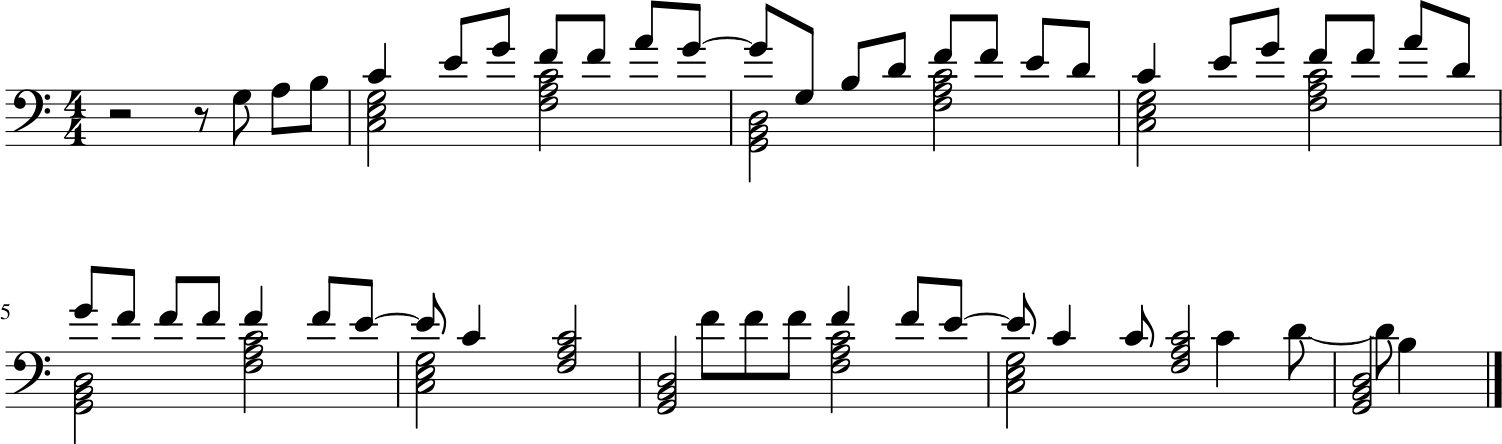

In [34]:
seed_stream = npenc2stream(seed_np)
seed_stream.show()

In [35]:
xb

tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  73, 141,   8, 141,  71, 141,   8, 141,
          69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,   8, 141,
          76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,   8, 141,
          74, 141,   8, 141,  78, 141,   8, 141,  71, 141,   8, 141,  76, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  74, 141,   8, 141,  74, 141,
           8, 141,  74, 141,   8, 141,  74, 143,  69, 147,  66, 147,  62, 147,
           8, 143,  74, 141,   8, 141,  73, 143,   8

In [36]:
self = learn
task_type = torch.full_like(xb, TaskType.NextWord.value)
# res = self.pred_batch(batch=((xb,task_type,xb),(xb)))[-1][0, -1] # task1, task2 - (bs x ts x vocab)

In [37]:
res = self.pred_batch(batch=((xb,task_type,xb),xb)); res

[tensor([[[5.8468e-03, 9.5260e-04, 2.3095e-04,  ..., 2.3689e-04,
           5.5836e-04, 3.0180e-04],
          [2.7480e-04, 3.3293e-03, 4.5036e-05,  ..., 5.0636e-05,
           8.6134e-05, 6.6950e-05],
          [5.8710e-05, 2.2157e-04, 1.0383e-05,  ..., 1.0924e-05,
           1.7525e-05, 1.4931e-05],
          ...,
          [7.3781e-05, 2.5324e-05, 2.8302e-06,  ..., 5.2464e-06,
           8.4660e-06, 8.3023e-06],
          [5.2489e-06, 3.2248e-05, 4.2918e-07,  ..., 6.1237e-07,
           4.9013e-07, 8.0810e-07],
          [7.8965e-05, 4.1693e-05, 3.4797e-06,  ..., 6.3255e-06,
           1.1058e-05, 9.8163e-06]]]),
 tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [38]:
last = res[-1][0, -1]; last[143]

tensor(0.1738)

In [39]:

idx = torch.multinomial(res[-1][0, -1], 1).item(); idx

141

In [56]:

def predict_nw(self, xb:Tensor, n_words:int=128):
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy().squeeze()
    yb = torch.ones_like(xb)
    new_idx = []

    for i in progress_bar(range(n_words), leave=True):
#         print(xb)
        task_type = torch.full_like(xb, TaskType.NextWord.value)
        
        # Masking last - bert
#         mask_last = torch.cat((xb, torch.tensor(vocab.mask_idx, device=xb.device).view(1, 1)), dim=-1)
#         res = self.pred_batch(batch=((mask_last,task_type,mask_last),(yb)))[0][0, -1] # task1, task2 - (bs x ts x vocab)
        
        # Next Word
        res = self.pred_batch(batch=((xb,task_type,xb),xb))[-1][0, -1] # task1, task2 - (bs x ts x vocab)

        # Use first temperatures value if last prediction was duration
        res.pow_(1 / (0.5))

        idx = torch.multinomial(res, 1).item()
    
        new_idx.append(idx)
        t_idx = torch.tensor(idx, device=xb.device).view(1, 1)
        xb = torch.cat((xb, t_idx), dim=-1)
#         xb = xb.new_tensor([idx])[None]
        
    return np.array(new_idx), seed


In [57]:
# vocab.itos[143]

In [58]:
# self = learn
# if xb.shape[0] > 1: xb = xb[0][None]
# seed = xb.cpu().numpy().squeeze()
# yb = torch.ones_like(xb)
# res = self.pred_batch(batch=((xb, torch.full_like(xb, TaskType.NextWord.value),xb),(yb)))
# res[-1][0, -1].shape

In [59]:
out_s, seed_s = predict_nw(learn, xb, n_words=20)

In [60]:
out_s

array([141, 141, 141, 141, 141, 141,   8, 141, 141, 141, 141, 141, 141, 141, 143, 141, 141, 141, 141, 141])

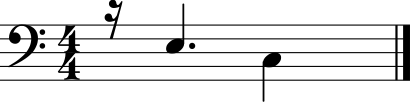

In [55]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

In [64]:
%debug

> /home/ubuntu/midi_generator/src/encode_data.py(194)seq2chordarr()
    192 # 2.
    193 def seq2chordarr(seq, note_range=128): # 128 = default midi range
--> 194     num_parts = max([n.ival() for t in seq for n in t]) + 1
    195     score_arr = np.zeros((len(seq), num_parts, note_range))
    196     for idx,ts in enumerate(seq):

ipdb> quit
